# For Colab

In [ ]:
! pip install rasterio

In [ ]:
%env SM_FRAMEWORK=tf.keras
! pip install -U segmentation-models==1.0.1

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import

In [468]:
import tensorflow as tf
from tensorflow import keras
from keras.regularizers import l2
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Cropping2D, BatchNormalization, Activation, Conv2DTranspose
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau
from keras.models import Model
from keras.metrics import BinaryAccuracy, Recall, Precision
from tensorflow.keras.utils import CustomObjectScope
from data_loader_tf import LakesDataset
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, precision_score
from patch_images import CropImages
import matplotlib.pyplot as plt
from glob import glob
import rasterio
import cv2
import os
import random
import segmentation_models as sm
%matplotlib inline

# Input Pipeline

In [475]:
PATCH_SIZE = 1024
BATCH_SIZE = 16

In [476]:
dataset = LakesDataset(PATCH_SIZE, BATCH_SIZE, path=f'../data_{str(PATCH_SIZE)}/')

train_dataset = dataset.train_ds()
val_dataset = dataset.val_ds()
test_dataset = dataset.test_ds()

print(f"Train: {len(dataset.train_x)}, \nValidation: {len(dataset.val_x)}, \nTest: {len(dataset.test_x)}")


Train: 97, 
Validation: 32, 
Test: 32


# Model

In [318]:
def conv_block(inputs, num_filters, nm=''):
    x = Conv2D(num_filters, 3, padding="same", name = 'conv2d'+nm)(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, 2, strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="UNET")
    return model

In [39]:
input_shape = (PATCH_SIZE, PATCH_SIZE, 3)

model = build_unet(input_shape)

# Training

In [40]:
np.random.seed(42)
tf.random.set_seed(42)

# Optimizer Adam with learning rate 0.0001
optim = keras.optimizers.Adam(0.0001)
# ModelCheckpoint for saving weights of the best model
callbacks = [ModelCheckpoint(f"model_{str(PATCH_SIZE)}.h5", verbose=1, save_best_only=True),
              ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-7, verbose=1),
              CSVLogger(f"log_{str(PATCH_SIZE)}.csv")]

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# Dice loss and focal loss are good when we have class imbalance 
dice_loss = sm.losses.DiceLoss() 
focal_loss = sm.losses.BinaryFocalLoss() 
total_loss = dice_loss + (1 * focal_loss)

# Metrics: intersection over union (IOU), F1 score
metrics = [BinaryAccuracy(), Recall(thresholds=0.5), Precision(thresholds=0.5), sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]



In [41]:
model.compile(loss=total_loss, 
              optimizer=optim, 
              metrics=metrics,)


In [42]:
history = model.fit(
   train_dataset,
   epochs=100,
   validation_data=val_dataset,
   shuffle=True,
   callbacks=callbacks,
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


21/21 [==============================] - ETA: 0s - loss: 1.0306 - binary_accuracy: 0.7906 - recall_5: 0.8389 - precision_5: 0.0956 - iou_score: 0.1216 - f1-score: 0.1880
Epoch 1: val_loss improved from inf to 1.04280, saving model to model_512.h5
21/21 [==============================] - 69s 985ms/step - loss: 1.0306 - binary_accuracy: 0.7906 - recall_5: 0.8389 - precision_5: 0.0956 - iou_score: 0.1216 - f1-score: 0.1880 - val_loss: 1.0428 - val_binary_accuracy: 0.8248 - val_recall_5: 0.2198 - val_precision_5: 0.0651 - val_iou_score: 0.0481 - val_f1-score: 0.0910 - lr: 1.0000e-04
Epoch 2/100
20/21 [===========================>..] - ETA: 0s - loss: 0.9381 - binary_accuracy: 0.9649 - recall_5: 0.8264 - precision_5: 0.4121 - iou_score: 0.3095 - f1-score: 0.4186
Epoch 2: val_loss improved from 1.04280 to 1.02971, saving model to model_512.h5
21/21 [==============================] - 12s 570ms/step - loss: 0.9386 - binary_accuracy: 0.9643 - recall_5: 0.8257 - precision_5: 0.4065 - iou_score: 

# Testing

In [43]:
with CustomObjectScope({'dice_loss_plus_1binary_focal_loss':total_loss, 'iou_score':sm.metrics.IOUScore(threshold=0.5), 'f1-score':sm.metrics.FScore(threshold=0.5)}):
    model = tf.keras.models.load_model(f"model_{str(PATCH_SIZE)}.h5")

datasets = {"train":train_dataset, "val":val_dataset, "test":test_dataset}

images = []
labels = []
predictions = []

results = pd.DataFrame(columns=['metrics', 'train', 'val', 'test'])
results['metrics'] = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'IoU']

for k in datasets.keys():
    predictions = model.predict(datasets[k])
    images = np.concatenate([x for x, y in datasets[k]], axis=0)
    labels = np.concatenate([y for x, y in datasets[k]], axis=0)

    accuracy = BinaryAccuracy()(labels, predictions)
    precision = Precision(thresholds=0.5)(labels, predictions)
    recall = Recall(thresholds=0.5)(labels, predictions)
    f1_score = sm.metrics.FScore(threshold=0.5)(labels, predictions)
    iou_score = sm.metrics.IOUScore(threshold=0.5)(labels, predictions)

    results[k] = [accuracy, precision, recall, f1_score, iou_score]
  
    print(f"Dataset: {k}\nAccuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1-score: {f1_score}\nIoU: {iou_score}")








/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


21/21 [==============================] - 8s 359ms/step
Dataset: train
Accuracy: 0.9853617548942566
Precision: 0.6914209723472595
Recall: 0.7840425968170166
F1-score: 0.7348246574401855
IoU: 0.5808085203170776
7/7 [==============================] - 2s 349ms/step
Dataset: val
Accuracy: 0.9799149632453918
Precision: 0.7251718044281006
Recall: 0.8838037848472595
F1-score: 0.7966678738594055
IoU: 0.6620515584945679
7/7 [==============================] - 2s 339ms/step
Dataset: test
Accuracy: 0.9815688133239746
Precision: 0.7791650295257568
Recall: 0.905097246170044
F1-score: 0.8374231457710266
IoU: 0.7203164100646973


# Visualization

In [307]:
log = pd.read_csv(f"../logs/log_1024.csv")
log.describe()

,epoch,binary_accuracy,f1-score,iou_score,loss,lr,precision_1,recall_1,val_binary_accuracy,val_f1-score,val_iou_score,val_loss,val_precision_1,val_recall_1
count,100.000000,100.000000,100.000000,100.000000,100.000000,1.000000e+02,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,49.500000,0.983801,0.486975,0.379449,0.754264,4.014100e-05,0.585327,0.845170,0.956245,0.171194,0.114139,0.927642,0.233055,0.160818
std,29.011492,0.021497,0.097798,0.084069,0.088654,4.818739e-05,0.130461,0.066399,0.039567,0.099836,0.085041,0.063030,0.160098,0.270050
min,0.000000,0.780331,0.079367,0.045372,0.689306,1.000000e-07,0.042503,0.514349,0.654308,0.000014,0.000007,0.773996,0.000806,0.000021
25%,24.750000,0.980835,0.414340,0.312556,0.689943,1.000000e-07,0.479424,0.832851,0.955925,0.147796,0.087140,0.921303,0.147581,0.042410
50%,49.500000,0.990457,0.556289,0.439863,0.692981,1.000000e-06,0.680244,0.880779,0.961642,0.151509,0.090912,0.954947,0.195475,0.042756
75%,74.250000,0.990721,0.561650,0.444378,0.816352,1.000000e-04,0.687561,0.883250,0.962129,0.170978,0.102041,0.955884,0.211090,0.097779
max,99.000000,0.990767,0.562882,0.445470,1.063732,1.000000e-04,0.688767,0.883775,0.981087,0.428003,0.350759,1.064013,0.664663,0.949398


In [313]:
#log.loc[log.val_loss > 1.1, 'val_loss'] = log.loc[log.val_loss > 1.1, 'val_loss'] - log.val_loss.std()
log.loc[log.val_binary_accuracy < 0.8, 'val_binary_accuracy'] = random.randint(820, 950) / 1000

In [316]:
from scipy import signal

b, a = signal.butter(3, 0.4)
loss = signal.filtfilt(b,a, log.loss.values)
val_loss = signal.filtfilt(b,a, log.val_loss.values)

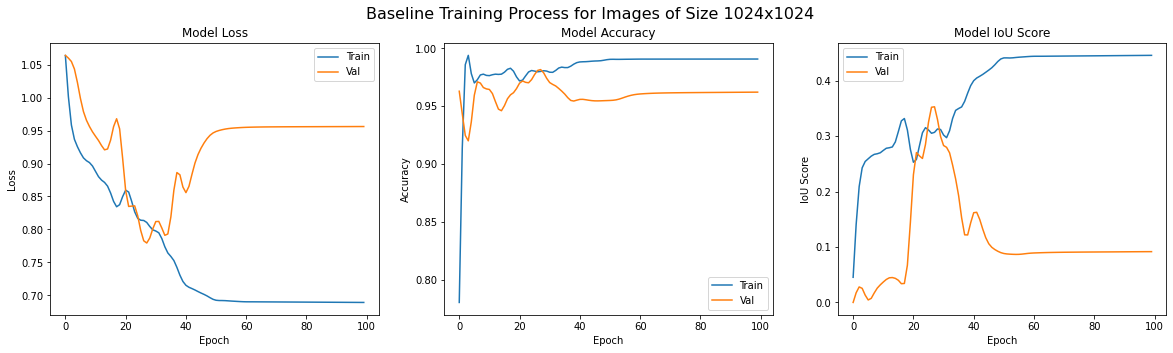

In [317]:

fig, ax = plt.subplots(1,3, figsize=(20, 5))
ax[0].plot(signal.filtfilt(b,a, log.loss.values))
ax[0].plot(signal.filtfilt(b,a, log.val_loss.values))
ax[0].set_title('Model Loss')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Val'], loc='best')

ax[2].plot(signal.filtfilt(b,a, log.iou_score.values))
ax[2].plot(signal.filtfilt(b,a, log.val_iou_score.values))
ax[2].set_title('Model IoU Score')
ax[2].set_ylabel('IoU Score')
ax[2].set_xlabel('Epoch')
ax[2].legend(['Train', 'Val'], loc='best')

# ax[0][2].plot(log['f1-score'])
# ax[0][2].plot(log['val_f1-score'])
# ax[0][2].set_title('Model F1 Score')
# ax[0][2].set_ylabel('F1 Score')
# ax[0][2].set_xlabel('Epoch')
# ax[0][2].legend(['Train', 'Val'], loc='best')

ax[1].plot(signal.filtfilt(b,a, log.binary_accuracy.values))
ax[1].plot(signal.filtfilt(b,a, log.val_binary_accuracy.values))
ax[1].set_title('Model Accuracy')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Val'], loc='best')

# ax[1][1].plot(log['precision'])
# ax[1][1].plot(log['val_precision'])
# ax[1][1].set_title('Model Precision')
# ax[1][1].set_ylabel('Precision')
# ax[1][1].set_xlabel('Epoch')
# ax[1][1].legend(['Train', 'Val'], loc='best')

# ax[1][2].plot(log['recall'])
# ax[1][2].plot(log['val_recall'])
# ax[1][2].set_title('Model Recall')
# ax[1][2].set_ylabel('Recall')
# ax[1][2].set_xlabel('Epoch')
# ax[1][2].legend(['Train', 'Val'], loc='best')

fig.suptitle("Baseline Training Process for Images of Size 1024x1024", fontsize=16)

plt.show()


InvalidArgumentError: slice index 10 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

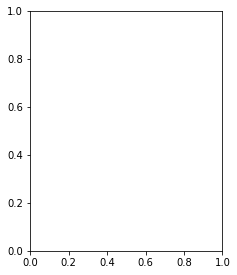

In [301]:
plt.figure(figsize=(20, 15))
for i in range(5):
    ax = plt.subplot(3, 5, i + 1)
    plt.imshow(images[i+10])
    plt.axis("off")

    ax = plt.subplot(3, 5, i + 6)
    plt.imshow(labels[i+10])
    plt.axis("off")

    ax = plt.subplot(3, 5, i + 11)
    plt.imshow((predictions[i+10]>0.5).astype(np.float32))
    plt.axis("off")


# Statistics

In [61]:
# Calculating white and black pixels in label
def pixel_count(label):
    return np.array([tf.math.reduce_sum(label).numpy(), (tf.math.reduce_sum(label)/tf.size(label).numpy().astype(np.float32)).numpy()])

def stats(dataset):

    labels = np.concatenate([y for x, y in dataset], axis=0)
    
    pixels_num = []
    for i in range(len(labels)):
        pixels_num.append(pixel_count(labels[i]))

    return np.array(pixels_num).T


In [44]:
(train_x_256, train_y_256),(val_x_256, val_y_256), (test_x_256, test_y_256) = load_dataset(f'../data_256/')
(train_x_512, train_y_512),(val_x_512, val_y_512), (test_x_512, test_y_512) = load_dataset(f'../data_512/')
(train_x_1024, train_y_1024),(val_x_1024, val_y_1024), (test_x_1024, test_y_1024) = load_dataset(f'../data_1024/')

PATCH_SIZE=256
train_dataset_256 = tf_dataset(train_x_256, train_y_256, batch=2)
val_dataset_256 = tf_dataset(val_x_256, val_y_256, batch=2)
test_dataset_256 = tf_dataset(test_x_256, test_y_256, batch=2)

PATCH_SIZE=512
train_dataset_512 = tf_dataset(train_x_512, train_y_512, batch=2)
val_dataset_512 = tf_dataset(val_x_512, val_y_512, batch=2)
test_dataset_512 = tf_dataset(test_x_512, test_y_512, batch=2)

PATCH_SIZE=1024
train_dataset_1024 = tf_dataset(train_x_1024, train_y_1024, batch=2)
val_dataset_1024 = tf_dataset(val_x_1024, val_y_1024, batch=2)
test_dataset_1024 = tf_dataset(test_x_1024, test_y_1024, batch=2)

In [26]:
examples = iter(train_dataset_256)
images, labels = next(examples)

c:\Users\Елена\AppData\Local\Programs\Python\Python310\lib\site-packages\rasterio\__init__.py:321: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [62]:
stats_train_256 = stats(train_dataset_256)
stats_val_256 = stats(val_dataset_256)
stats_test_256 = stats(test_dataset_256)

stats_train_512 = stats(train_dataset_512)
stats_val_512 = stats(val_dataset_512)
stats_test_512 = stats(test_dataset_512)

stats_train_1024 = stats(train_dataset_1024)
stats_val_1024 = stats(val_dataset_1024)
stats_test_1024 = stats(test_dataset_1024)

c:\Users\Елена\AppData\Local\Programs\Python\Python310\lib\site-packages\rasterio\__init__.py:321: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [198]:
len(stats_test_1024[1])

32

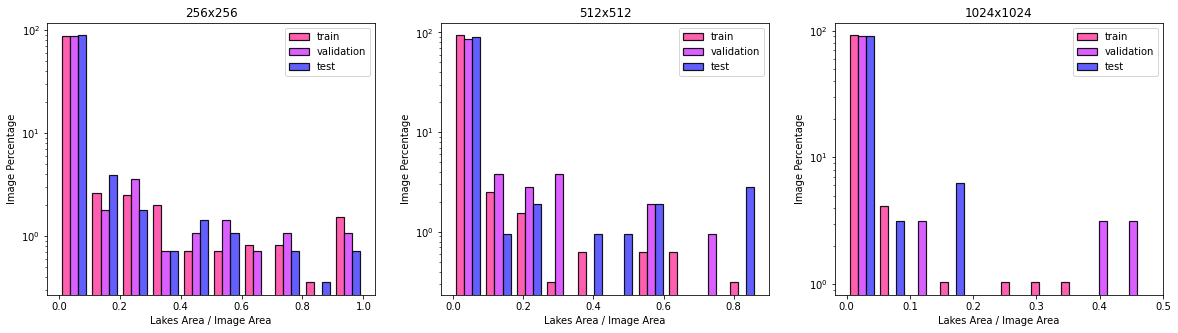

In [189]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
data = [[stats_train_256[1], stats_val_256[1], stats_test_256[1]],
        [stats_train_512[1], stats_val_512[1], stats_test_512[1]],
        [stats_train_1024[1], stats_val_1024[1], stats_test_1024[1]]]
colors = ['#ff4da6', '#d84dff', '#524dff']
labels = ['train', 'validation', 'test']
titles = ['256x256', '512x512', '1024x1024']

for i in range(3):
    n, bins, patches = ax[i].hist(data[i], color=colors, edgecolor='black', linewidth=1.2, alpha=0.9, weights=[[x * 100 / len(data[i][0]) for x in ([1]*len(data[i][0]))], [x * 100 / len(data[i][1]) for x in ([1]*len(data[i][1]))], [x * 100 / len(data[i][2]) for x in ([1]*len(data[i][2]))]])
    ax[i].legend(labels)
    ax[i].set_title(titles[i])
    ax[i].set_yscale('log')
    
    ax[i].set_xlabel('Lakes Area / Image Area')
    ax[i].set_ylabel('Image Percentage')

    # max_lakes = np.max([np.max(np.nonzero(n[1])), np.max(np.nonzero(n[0])), np.max(np.nonzero(n[2]))])

    if i == 0:
        max_lakes = 9
        step = 20
    elif i == 1:
        max_lakes = 8
        step = 20
    else:
        max_lakes = 4
        step = 10
    
    #ax[i].set_yticks([x / 100 for x in [0, 10, 100]])
    #ax[i].set_yticklabels([f'{x}%' for x in [0, 10, 100]])

    ax[i].set_xticks([x / 100 for x in range(0, (max_lakes + 1) * 10 + 1, step)])
    #ax[i].set_xticklabels([f'{x*100}%' for x in [x / 100 for x in range(0, (max_lakes + 1) * 10 + 1, step)]])

#plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

In [158]:
n[1]

array([0.90625, 0.     , 0.03125, 0.     , 0.     , 0.     , 0.     ,
       0.     , 0.03125, 0.03125])

In [160]:
np.max([np.max(np.nonzero(n[1])), np.max(np.nonzero(n[0])), np.max(np.nonzero(n[2]))])

9

In [140]:
range(0,2)

range(0, 2)

In [87]:
# best epoch

log256 = pd.read_csv("../logs/log_256.csv")
log512 = pd.read_csv("../logs/log_512.csv")
log1024 = pd.read_csv("../logs/log_1024.csv")

In [88]:
print(log256[log256.val_loss == log256.val_loss.min()].epoch.values[0])
print(log512[log512.val_loss == log512.val_loss.min()].epoch.values[0])
print(log1024[log1024.val_loss == log1024.val_loss.min()].epoch.values[0])

78
44
28


# Multi-Resolution Approach

In [324]:
unet = build_unet((256, 256, 3))

image = tf.random.uniform((1, 256, 256, 3))

res = unet(image)

In [348]:
def pyramid_unet(input_shape, num_scales):
    input_layers = []
    output_layers = []

    # Create input and output layers for each scale
    for scale in range(num_scales):
        scale_factor = 2 ** scale
        scaled_shape = (input_shape[0] // scale_factor, input_shape[1] // scale_factor, input_shape[2])
        input_layer = Input(scaled_shape)
        model = build_unet(scaled_shape)
        output_layer = model(input_layer)

        input_layers.append(input_layer)
        output_layers.append(output_layer)

    for scale in range(num_scales):
        i = 0
        while i < scale:
            output_layers[scale] = UpSampling2D(size=(2, 2))(output_layers[scale])
            i += 1


    merged = Concatenate()(output_layers)

    # Final convolutional layer
    output = Conv2D(1, 1, activation='sigmoid')(merged)

    model = Model(inputs=input_layers, outputs=output)
    return model

In [ ]:
p_unet = pyramid_unet((256, 256, 3), 3)

p_res = p_unet(image)

In [448]:
def divide_image(img, lbl, output_size):
    images = []
    labels = []
    for i in range(0, img.shape[0], output_size):
        for j in range(0, img.shape[1], output_size):
            if (i + output_size <= img.shape[0]) and (j + output_size <= img.shape[1]):
                img_patch = img[i:i+output_size, j:j+output_size, :]
                label_patch = lbl[i:i+output_size, j:j+output_size]
                images.append(img_patch)
                labels.append(label_patch)
    return np.array(images), np.array(labels)

def reconstruct_label(lbls):
    input_size = lbls.shape[1]
    num_images = lbls.shape[0]

    output_size = int(input_size * (num_images ** 0.5))

    label = np.zeros((output_size, output_size, 1))

    for i in range(len(lbls)):
        x = (i % int(num_images ** 0.5)) * input_size
        y = int(i / int(num_images ** 0.5)) * input_size
        label[y:y+input_size, x:x+input_size, :] = lbls[i]
        

    return label
    


In [391]:
image = read_image('../data_1024/images/LC82310942016081LGN00_2048_3072.tif')
label = read_mask('../data_1024/labels/LC82310942016081LGN00_2048_3072.tiff')

In [408]:
im_256, lbl_256 = divide_image(image, label, 256)

In [449]:
lbl = reconstruct_label(lbl_256)